In [10]:
pip install torch torchvision rasterio matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
from torch.utils.data import Dataset
import rasterio    #for geospatial data
import numpy as np


In [23]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FloodDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
        self.resize = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image = Image.open(self.image_paths[idx]).convert("RGB")
        
        mask = Image.open(self.mask_paths[idx]).convert("L")

        image = self.resize(image)
        mask = self.resize(mask)

        mask[mask > 0.5] = 1.0
        mask[mask <= 0.5] = 0.0

        return image, mask

In [24]:
import glob

img_dir = r"C:\Users\BIT\Downloads\sar_dataset\Image"   
mask_dir = r"C:\Users\BIT\Downloads\sar_dataset\Mask"   

image_paths = sorted(glob.glob(os.path.join(img_dir, "*")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))

print(f"Found {len(image_paths)} images and {len(mask_paths)} masks.")


if len(image_paths) != len(mask_paths):
    print("WARNING: Number of images and masks do not match!")
    min_len = min(len(image_paths), len(mask_paths))
    image_paths = image_paths[:min_len]
    mask_paths = mask_paths[:min_len]


real_dataset = FloodDataset(image_paths, mask_paths)
train_loader = DataLoader(real_dataset, batch_size=8, shuffle=True, num_workers=0)


images, masks = next(iter(train_loader))
print(f"Batch Image Shape: {images.shape}") 
print(f"Batch Mask Shape:  {masks.shape}")  

Found 290 images and 290 masks.
Batch Image Shape: torch.Size([8, 3, 256, 256])
Batch Mask Shape:  torch.Size([8, 1, 256, 256])


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2d => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes


        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))


        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up1 = DoubleConv(1024 + 512, 512)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up2 = DoubleConv(512 + 256, 256)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up3 = DoubleConv(256 + 128, 128)

        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up4 = DoubleConv(128 + 64, 64)


        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv_up1(x)

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv_up2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv_up3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv_up4(x)

        logits = self.outc(x)
        return logits

In [15]:

model = UNet(n_channels=3, n_classes=1)
output = model(images)

print(f"Input Shape:  {images.shape}")
print(f"Output Shape: {output.shape}")


Input Shape:  torch.Size([8, 3, 256, 256])
Output Shape: torch.Size([8, 1, 256, 256])


In [17]:
import torch.optim as optim

learning_rate = 1e-4
num_epochs = 10 

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

import time


print(f"Starting training on: {device}")
print(f"Total batches per epoch: {len(train_loader)}")

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    start_time = time.time()
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Current Loss: {loss.item():.4f}")

    epoch_duration = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] Finished. Avg Loss: {running_loss/len(train_loader):.4f}. Time: {epoch_duration:.0f}s")

Starting training on: cpu
Total batches per epoch: 37
  Epoch [1/10], Batch [10/37], Current Loss: 0.3599
  Epoch [1/10], Batch [20/37], Current Loss: 0.4494
  Epoch [1/10], Batch [30/37], Current Loss: 0.4273
Epoch [1/10] Finished. Avg Loss: 0.4306. Time: 611s
  Epoch [2/10], Batch [10/37], Current Loss: 0.3370
  Epoch [2/10], Batch [20/37], Current Loss: 0.4580
  Epoch [2/10], Batch [30/37], Current Loss: 0.3383
Epoch [2/10] Finished. Avg Loss: 0.3763. Time: 517s
  Epoch [3/10], Batch [10/37], Current Loss: 0.3275
  Epoch [3/10], Batch [20/37], Current Loss: 0.4142
  Epoch [3/10], Batch [30/37], Current Loss: 0.4776
Epoch [3/10] Finished. Avg Loss: 0.3646. Time: 514s
  Epoch [4/10], Batch [10/37], Current Loss: 0.3977
  Epoch [4/10], Batch [20/37], Current Loss: 0.4054
  Epoch [4/10], Batch [30/37], Current Loss: 0.3598
Epoch [4/10] Finished. Avg Loss: 0.3782. Time: 527s
  Epoch [5/10], Batch [10/37], Current Loss: 0.3393
  Epoch [5/10], Batch [20/37], Current Loss: 0.2927
  Epoch [5

In [25]:

torch.save(model.state_dict(), "flood_model_final.pth")


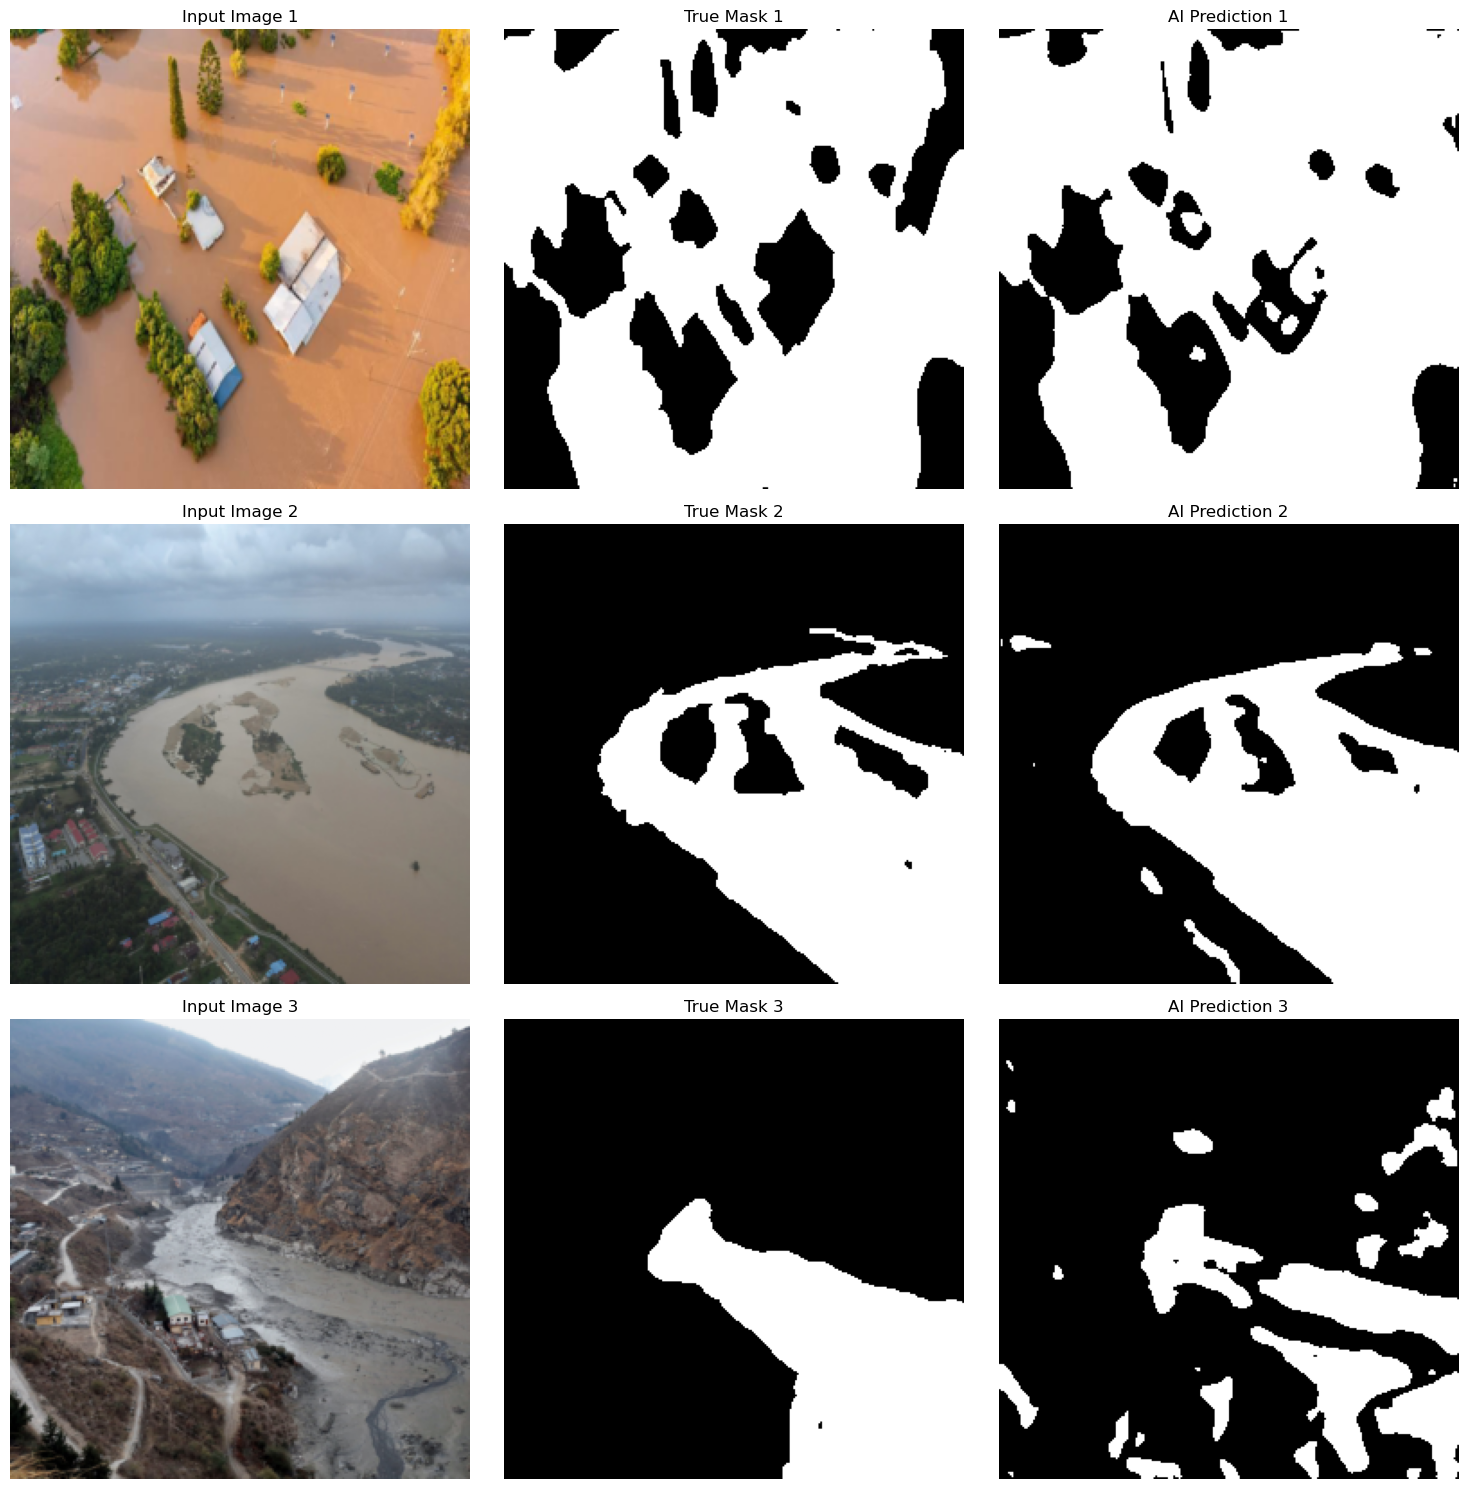

In [26]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

data_iter = iter(train_loader)
images, labels = next(data_iter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = (torch.sigmoid(outputs) > 0.5).float()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    img_display = images[i].cpu().permute(1, 2, 0).numpy()

    label_display = labels[i].cpu().squeeze().numpy()
    pred_display = preds[i].cpu().squeeze().numpy()

    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f"Input Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(label_display, cmap='gray')
    axes[i, 1].set_title(f"True Mask {i+1}")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pred_display, cmap='gray')
    axes[i, 2].set_title(f"AI Prediction {i+1}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()